<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/Small_Imagenet_VGG_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
colorization_path = '/content/drive/MyDrive/colorization'
!tar -zxf /content/drive/MyDrive/colorization/smallval.tar.gz

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [6]:

def stack_lab(l, ab):
  return torch.cat((l, ab), dim=-3)

def lab2rgb(lab, to_numpy):
  dims = len(lab.shape)
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0)) if dims==3 else lab.permute((0,2,3,1))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy(rgb).permute(2,0,1) if dims==3 else torch.from_numpy(rgb).permute((0,3,1,2))

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using Imagenet validation set

In [7]:
# image processing rgb to lab
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.transform = transform
        self.data = datasets.ImageFolder(folder_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, _ = self.data[index]

        if self.transform:
            image = self.transform(image)

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))


        return L, ab

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256,256))
])

# data_dir = '/content/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/'
data_dir = '/content/ILSVRC2012_img_val_subset'
dataset = ColorizationDataset(data_dir, transform)


In [8]:
train_size = int(.8* len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator()
generator.manual_seed(0)
train_data, val_data = random_split(dataset, [train_size, val_size], generator=generator)


In [9]:
gray, chrome = train_data[0]
gray.shape, chrome.shape

(torch.Size([1, 256, 256]), torch.Size([2, 256, 256]))

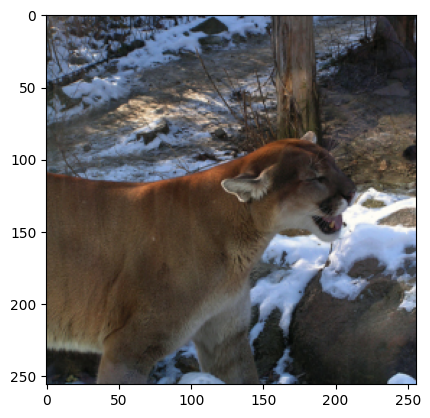

In [10]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

# III. Training Experimentation

## 0. utils

In [11]:
from tqdm import tqdm

def train_loop(model, loader, optimizer, backprop_loss=1):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0

    for grayscale_images, colored_images in tqdm(loader, leave=False):
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)
        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss1 = nn.L1Loss()(predicted_images, colored_images)
        loss2 = nn.MSELoss()(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss = loss1 + loss2 if backprop_loss==0 else loss1 if backprop_loss==1 else loss2
        loss.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        running_loss2 += loss2.item()

    # Calculate average loss
    average_loss1 = running_loss1 / len(loader)
    average_loss2 = running_loss2 / len(loader)

    return average_loss1, average_loss2

def plot_loss(loss, title, save_path):
    epochs = range(len(loss))

    # Plotting the losses
    plt.plot(epochs, loss)
    # Customize the plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)

    # Save the plot
    plt.savefig(save_path)
    plt.show()

    # Close the plot to free up resources
    plt.close()


# Train VGG UNet on imagenet validation set

In [4]:
! pip install -qU segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00


In [ ]:
from torchvision.models.resnet import resnet101
import segmentation_models_pytorch as smp

class UNet(nn.Module):
  def __init__(self, encoder_name, encoder_weights = 'imagenet', freeze_encoder = True):
    super().__init__()

    self.model = smp.Unet(encoder_name, encoder_weights=encoder_weights, decoder_use_batchnorm=True, in_channels=1)
    self.model.segmentation_head[0] = nn.Conv2d(16, 2, kernel_size=3, padding=1)

    if freeze_encoder:
      for param in self.model.encoder.parameters():
        param.requires_grad = False

  def forward(self, x):
    return self.model(x)

# res_unet= UNet(encoder_name='resnet152',encoder_weights='imagenet',freeze_encoder=True)
vgg_unet= UNet(encoder_name='vgg19_bn',encoder_weights='imagenet',freeze_encoder=True)
model = vgg_unet
model_name = 'small-VGG-UNET-L2'

In [ ]:
# config
backprop_loss = 2
batch_size = 32
model.to(device)

# Initialize U-Net model and loader and optimizer
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters())

# training loop
l1_hist = []
l2_hist = []

Epoch 1/50:  MAE Loss: 9.777311477661133, MSE Loss: 233.05460986328126


Epoch 2/50:  MAE Loss: 9.5090199508667, MSE Loss: 207.67327160644533


Epoch 3/50:  MAE Loss: 9.400785331726075, MSE Loss: 201.71751000976562


Epoch 4/50:  MAE Loss: 9.324582401275634, MSE Loss: 197.33639276123046


Epoch 5/50:  MAE Loss: 9.189518684387208, MSE Loss: 192.87710198974608


Epoch 6/50:  MAE Loss: 9.113695697784424, MSE Loss: 189.23794604492187


Epoch 7/50:  MAE Loss: 8.957147319793702, MSE Loss: 183.3013524169922


Epoch 8/50:  MAE Loss: 8.807300189971924, MSE Loss: 177.3407504272461


Epoch 9/50:  MAE Loss: 8.684037307739258, MSE Loss: 172.16938385009766


Epoch 10/50:  MAE Loss: 8.524821685791016, MSE Loss: 167.27025512695312


Epoch 11/50:  MAE Loss: 8.359009399414063, MSE Loss: 160.8018442993164


Epoch 12/50:  MAE Loss: 8.288452320098877, MSE Loss: 157.73217395019532


Epoch 13/50:  MAE Loss: 8.045319438934326, MSE Loss: 149.66280114746093


Epoch 14/50:  MAE Loss: 7.876577713012695, MSE Loss: 143.80126574707032


Epoch 15/50:  MAE Loss: 7.731012966156006, MSE Loss: 138.20724066162109


Epoch 16/50:  MAE Loss: 7.588862930297852, MSE Loss: 134.31225341796875


Epoch 17/50:  MAE Loss: 7.50048815536499, MSE Loss: 130.60692047119142


Epoch 18/50:  MAE Loss: 7.390254306793213, MSE Loss: 127.28676049804687


Epoch 19/50:  MAE Loss: 7.331540912628173, MSE Loss: 123.11427545166016


Epoch 20/50:  MAE Loss: 7.2177902030944825, MSE Loss: 117.9819786376953


Epoch 21/50:  MAE Loss: 7.0441363983154295, MSE Loss: 111.75855871582031


Epoch 22/50:  MAE Loss: 6.9319825286865235, MSE Loss: 108.2950506591797


Epoch 23/50:  MAE Loss: 6.860307094573975, MSE Loss: 105.68768872070312


Epoch 24/50:  MAE Loss: 6.774907508850098, MSE Loss: 102.33848663330077


Epoch 25/50:  MAE Loss: 6.687487545013428, MSE Loss: 99.36990832519531


Epoch 26/50:  MAE Loss: 6.45929515838623, MSE Loss: 93.23572048950196


Epoch 27/50:  MAE Loss: 6.423943954467774, MSE Loss: 92.17531628417969


Epoch 28/50:  MAE Loss: 6.3819762763977055, MSE Loss: 90.33764025878907


Epoch 29/50:  MAE Loss: 6.293294441223145, MSE Loss: 88.05893606567383


Epoch 30/50:  MAE Loss: 6.192729206085205, MSE Loss: 85.52251000976563


Epoch 31/50:  MAE Loss: 6.214575115203857, MSE Loss: 85.655365234375


Epoch 32/50:  MAE Loss: 5.998019744873047, MSE Loss: 80.1846830444336


Epoch 33/50:  MAE Loss: 5.944489631652832, MSE Loss: 78.87293328857422


Epoch 34/50:  MAE Loss: 5.9275847434997555, MSE Loss: 78.14413562011718


Epoch 35/50:  MAE Loss: 5.8672383003234865, MSE Loss: 76.17035208129883


Epoch 36/50:  MAE Loss: 5.827890953063965, MSE Loss: 75.45272393798828


Epoch 37/50:  MAE Loss: 5.724381301879883, MSE Loss: 73.26795568847656


Epoch 38/50:  MAE Loss: 5.755607845306397, MSE Loss: 73.36211734008789


Epoch 39/50:  MAE Loss: 5.62771138381958, MSE Loss: 70.55856497192383


Epoch 40/50:  MAE Loss: 5.589796867370605, MSE Loss: 69.79193090820313


Epoch 41/50:  MAE Loss: 5.564837890625, MSE Loss: 68.77736489868164


Epoch 42/50:  MAE Loss: 5.473777751922608, MSE Loss: 67.06607885742187


Epoch 43/50:  MAE Loss: 5.4501500434875485, MSE Loss: 66.07521252441406


Epoch 44/50:  MAE Loss: 5.438503932952881, MSE Loss: 65.51930767822266


Epoch 45/50:  MAE Loss: 5.398179092407227, MSE Loss: 64.80377474975586


Epoch 46/50:  MAE Loss: 5.389209712982177, MSE Loss: 64.56647137451172


Epoch 47/50:  MAE Loss: 5.323037559509277, MSE Loss: 62.619056213378904


Epoch 48/50:  MAE Loss: 5.3338476715087895, MSE Loss: 63.262891204833984


Epoch 49/50:  MAE Loss: 5.305179943084717, MSE Loss: 62.46417065429687


Epoch 50/50:  MAE Loss: 5.169419506072998, MSE Loss: 59.33980084228516


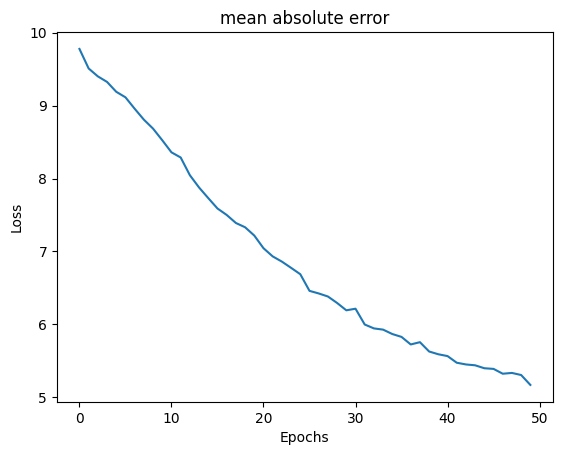

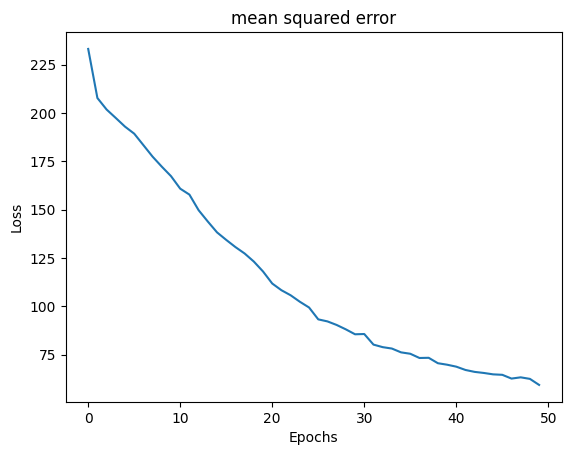

In [ ]:
epochs = 50
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [ ]:
epochs = 20
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)

Epoch 1/20:  MAE Loss: 5.223284191131592, MSE Loss: 60.39572283935547


Epoch 2/20:  MAE Loss: 5.227841011047364, MSE Loss: 60.28169201660156


Epoch 3/20:  MAE Loss: 5.18089737701416, MSE Loss: 59.46488507080078


Epoch 4/20:  MAE Loss: 5.105409240722656, MSE Loss: 58.073009063720704


Epoch 5/20:  MAE Loss: 5.128495182037353, MSE Loss: 58.19603192138672


Epoch 6/20:  MAE Loss: 5.094691440582276, MSE Loss: 57.302136352539065


Epoch 7/20:  MAE Loss: 5.126024269104004, MSE Loss: 57.88048727416992


Epoch 8/20:  MAE Loss: 4.987006671905518, MSE Loss: 55.28260192871094


Epoch 9/20:  MAE Loss: 5.036783809661865, MSE Loss: 55.91225573730469


Epoch 10/20:  MAE Loss: 5.046493419647216, MSE Loss: 55.966158020019535


Epoch 11/20:  MAE Loss: 4.940034477233887, MSE Loss: 53.98583056640625


Epoch 12/20:  MAE Loss: 5.001419425964356, MSE Loss: 55.190523834228514


Epoch 13/20:  MAE Loss: 4.963031517028808, MSE Loss: 54.223778442382816


Epoch 14/20:  MAE Loss: 4.918145618438721, MSE Loss: 53.32845233154297


Epoch 15/20:  MAE Loss: 4.882465419769287, MSE Loss: 52.44283026123047


Epoch 16/20:  MAE Loss: 4.843504989624024, MSE Loss: 51.829498657226566


Epoch 17/20:  MAE Loss: 4.851275016784668, MSE Loss: 51.923399078369144


Epoch 18/20:  MAE Loss: 4.831236968994141, MSE Loss: 51.55966146850586


Epoch 19/20:  MAE Loss: 4.790346115112305, MSE Loss: 50.96934713745117


Epoch 20/20:  MAE Loss: 4.804023933410645, MSE Loss: 50.849390258789064


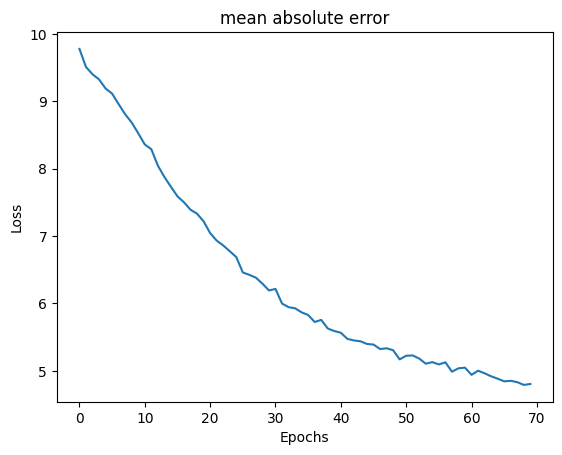

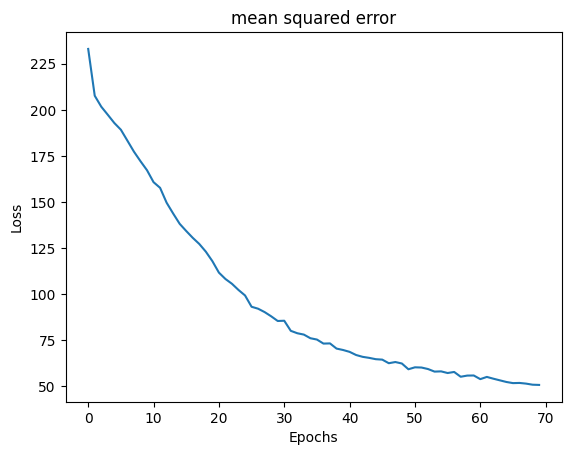

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [ ]:
epochs = 20
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)

Epoch 1/20:  MAE Loss: 4.784259063720703, MSE Loss: 50.56457034301758


Epoch 2/20:  MAE Loss: 4.756582328796386, MSE Loss: 49.983457611083985


Epoch 3/20:  MAE Loss: 4.758631320953369, MSE Loss: 50.04808544921875


Epoch 4/20:  MAE Loss: 4.765707855224609, MSE Loss: 50.02075537109375


Epoch 5/20:  MAE Loss: 4.708161312103272, MSE Loss: 49.03063897705078


Epoch 6/20:  MAE Loss: 4.717934059143066, MSE Loss: 49.20646676635742


Epoch 7/20:  MAE Loss: 4.730705373764038, MSE Loss: 49.272756927490235


Epoch 8/20:  MAE Loss: 4.620224391937255, MSE Loss: 47.26869741821289


Epoch 9/20:  MAE Loss: 4.622776481628418, MSE Loss: 47.20448651123047


Epoch 10/20:  MAE Loss: 4.63917310333252, MSE Loss: 47.60577529907226


Epoch 11/20:  MAE Loss: 4.5533696537017825, MSE Loss: 45.872366241455076


Epoch 12/20:  MAE Loss: 4.580793882369995, MSE Loss: 46.39002137756348


Epoch 13/20:  MAE Loss: 4.612214075088501, MSE Loss: 47.126187393188474


Epoch 14/20:  MAE Loss: 4.598288745880127, MSE Loss: 46.602949798583985


Epoch 15/20:  MAE Loss: 4.48871576499939, MSE Loss: 44.67551907348633


Epoch 16/20:  MAE Loss: 4.514363939285278, MSE Loss: 45.28650250244141


Epoch 17/20:  MAE Loss: 4.568202747344971, MSE Loss: 45.960556243896484


Epoch 18/20:  MAE Loss: 4.50217519569397, MSE Loss: 44.889113800048825


Epoch 19/20:  MAE Loss: 4.464729427337646, MSE Loss: 44.3057356262207


Epoch 20/20:  MAE Loss: 4.5137863464355465, MSE Loss: 45.04837841796875


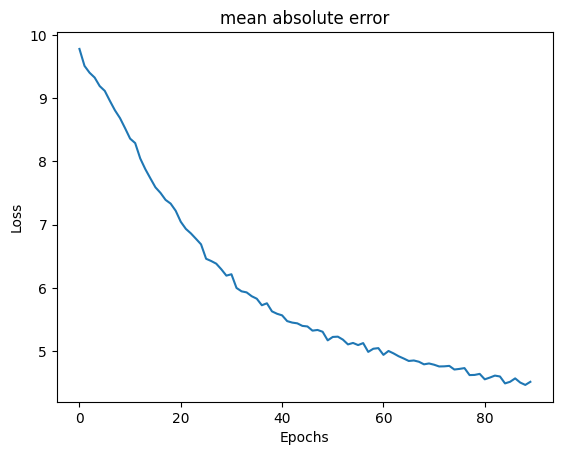

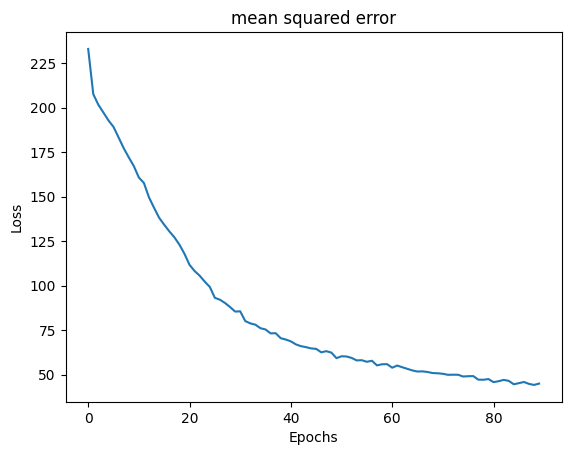

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [14]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from torch.types import Device
from lpips import LPIPS

lpips_alex = LPIPS(net='alex')

def lpips_evaluate(model, loader):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colors in loader:
            grayscale_images = grayscale_images.to(device)
            colors = colors.to(device)

            # Forward pass
            predicted_colors = model(grayscale_images)

            # Compute the loss
            predicted_rgb = to_rgb(grayscale_images.cpu(), predicted_colors.cpu(), to_numpy = False)
            label_rgb = to_rgb(grayscale_images.cpu(), colors.cpu(), to_numpy = False)

            loss = lpips_alex(predicted_rgb, label_rgb)

            # Accumulate loss
            running_loss += loss.sum().item() / len(loss)

    # Calculate average loss
    average_loss = running_loss / len(loader)

    return average_loss


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 97.2MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [16]:

testloader = DataLoader(val_data, batch_size=32)
lpips_score = lpips_evaluate(model, testloader)

print(f'LPIPS results on test data:{lpips_score}')

LPIPS results on test data:0.12912689778022468


# Colorizing Unseen Data with implemented model

torch.Size([2, 256, 256])
401


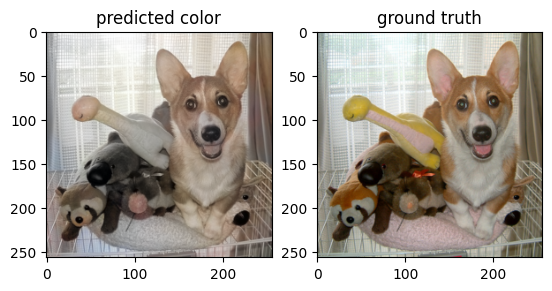

In [38]:
import random
model.eval()

index = random.randint(0,len(val_data))
input, label = val_data[index]
rgb_label = to_rgb(input, label)

input = input.to(device)
output = model(input.unsqueeze(0)).squeeze()
print(output.shape)
rgb_pred = to_rgb(input.cpu(), output.cpu())

input.shape, label.shape, output.shape
rgb_pred.shape, rgb_label.shape
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2)


axes[0].imshow(rgb_pred)
axes[0].set_title('predicted color')

axes[1].imshow(rgb_label)
axes[1].set_title('ground truth')
print(index)